In [1]:
# Reading in the data:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
trainData = pd.read_csv('../data/1e7data_train.csv', index_col=0)
testData = pd.read_csv('../data/1e7data_holdout.csv', index_col=0)
df = trainData
dftest = testData
df.tail()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,norm_min_e2,norm_min_window10_e2,norm_min_e3,norm_min_window10_e3,norm_min_inc1,norm_min_window10_inc1,norm_min_inc2,norm_min_window10_inc2,norm_min_inc3,norm_min_window10_inc3
Sim_ID,,,,,,,,,,,,,,,,,,,,,
4465,True,1.000000e+07,10000000.0,0.000015,0.021544,0.049234,0.010924,0.011821,2.166832,0.011453,...,0.000584,0.025326,0.000058,0.010939,0.000067,0.000212,0.000205,0.001258,0.002236,0.004439
4231,False,5.556366e+05,10000000.0,0.000015,0.021544,0.043888,0.009194,0.004916,-1.426257,0.007699,...,0.000374,0.155129,0.000066,0.002199,0.000106,0.000375,0.000007,0.034136,0.000070,0.000463
487,False,1.955824e+06,10000000.0,0.000015,0.021544,0.056372,0.013384,0.006294,-0.410190,0.003253,...,0.000039,0.023756,0.000583,0.002526,0.000630,0.003254,0.000256,0.000608,0.000759,0.000256
2210,False,4.607903e+03,10000000.0,0.000015,0.021544,0.054535,0.012735,0.007372,-1.748617,0.015612,...,0.000702,0.005107,0.000400,0.006366,0.005785,0.000889,0.000212,0.000663,0.000126,0.000314
4390,True,1.000000e+07,10000000.0,0.000015,0.021544,0.042994,0.008915,0.009054,2.988464,0.013263,...,0.000565,0.008115,0.000088,0.010731,0.000342,0.000861,0.000082,0.001282,0.000835,0.000491


In [2]:
# choosing the appropriate features:
features = ['daOverRH1', 'daOverRH2']
for i in ['1', '2', '3']:
    #columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i, 'x'+i, 'y'+i, 'z'+i, 'vx'+i, 'vy'+i, 'vz'+i]
    features += ['P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]

y = df['Stable']
X = df[features]
X.head()

,daOverRH1,daOverRH2,P1,e1,pomega1,inc1,Omega1,f1,P2,e2,pomega2,inc2,Omega2,f2,P3,e3,pomega3,inc3,Omega3,f3
Sim_ID,,,,,,,,,,,,,,,,,,,,
2414,8.989360,6.969123,0.013449,0.008127,-4.462116,0.003942,-3.134668,1.949717,0.017539,0.016039,-4.172961,0.002068,-1.855286,1.462877,0.021633,0.006592,1.995330,0.010630,2.969187,-1.685085
4056,5.924768,5.095487,0.011447,0.005201,4.606446,0.009269,2.392131,-3.975319,0.013707,0.015913,1.059685,0.000349,1.279611,1.308241,0.016025,0.007400,-3.935502,0.009493,-1.889784,-0.745085
4855,7.241825,8.398691,0.012241,0.004883,0.605644,0.000564,0.316897,1.688171,0.015214,0.010873,0.453809,0.016510,-0.394784,-2.362605,0.019525,0.005741,-5.758388,0.005166,-2.642989,0.399412
517,8.840869,8.943640,0.013338,0.008056,1.245784,0.007544,1.086138,-1.006037,0.017325,0.006096,0.791898,0.002616,-0.707993,-3.734544,0.022566,0.016438,-0.505355,0.015843,1.975103,-0.395186
1520,5.908519,5.085694,0.010603,0.012062,-0.577740,0.005068,-1.083953,-0.133573,0.012690,0.006588,0.348393,0.012850,-2.202099,-1.864266,0.014832,0.012144,0.102143,0.000987,-2.638114,-3.562545


In [3]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import ipywidgets as widgets
from ipywidgets import FloatSlider, fixed
from ipywidgets.widgets.widget_selection import SelectionSlider

This function, adapted from Diana's notebook, does CV on the passed model, and prints out the optimal number of iterations for the adopted hyperparameters (`xgb.cv` will run up to `n_estimators` rounds, but if the CV score doesn't improve in `early_stopping_rounds` rounds, it will stop, and will return the sequence of CV scores with the last 50 cut out).

In [5]:
model = XGBClassifier(seed=27, learning_rate=0.1, n_estimators=400) # taken from fitting ROC_AUC

I next tried to optimize `max_depth` and `min_child_weight` simultaneously.  This is not what Kristen suggested, but I was playing around and seeing as this data set is so tiny, there's no computational bottleneck at all.  `max_depth` is the depth of the trees, and we only have about 20 features, so don't need to test values > 20.

Here I set the ranges for the parameters

In [6]:
Nfolds = 5
max_depth = [6,12,18]
min_child_weight = np.logspace(-1,2,5)

param_grid = dict(max_depth=max_depth, min_child_weight=min_child_weight)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='average_precision',iid=False, cv=Nfolds)
grid.fit(df[features],df['Stable'])

# get the names of the parameters
param_names = param_grid.keys()
param_vals = [[val for val in param_grid[param_name]] for param_name in param_names]
param_val_names = {param_name:["{0}".format(val) for val in param_grid[param_name]] for param_name in param_names}

I wrote some functions to help visualize the results

In [7]:
%matplotlib inline
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plotgrid(grid, vmin, vmax, midpoint):
    param_grid = grid.param_grid
    
    # get the names of the parameters
    param1 = param_grid.keys()[0]
    param2 = param_grid.keys()[1]

    # plot the scores of the grid
    # grid_scores_ contains parameter settings and scores
    # We extract just the scores
    scores = np.fabs([x[1] for x in grid.grid_scores_])
    scores = np.array(scores).reshape(len(param_grid[param1]), len(param_grid[param2]))

    plt.figure(figsize=(12, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint))
    plt.xlabel(param2)
    plt.ylabel(param1)
    plt.colorbar()
    plt.xticks(np.arange(len(param_grid[param2])), np.round(param_grid[param2], decimals=2))
    plt.yticks(np.arange(len(param_grid[param1])), np.round(param_grid[param1], decimals=2))
    plt.title('CV Score')
    plt.show()
       
def plot1dcut(grid, param_names, fixed_param_name, fixed_value_name):
    fixed_value = float(fixed_value_name)
    param_grid = grid.param_grid
    
    # Each entry x in grid.grid_scores_ has all the CV scores in x[2]
    scores = np.fabs([np.mean(x[2]) for x in grid.grid_scores_])
    stds = np.fabs([np.std(x[2]) for x in grid.grid_scores_])
    scores = np.array(scores).reshape(len(param_grid[param_names[0]]), len(param_grid[param_names[1]]))
    stds = np.array(stds).reshape(len(param_grid[param_names[0]]), len(param_grid[param_names[1]]))
    
    plt.figure(figsize=(8, 6))
    fig, ax = plt.subplots()
    
    if fixed_param_name == param_names[0]:
        xvals = param_grid[param_names[1]] # take all the values in param grid for the other parameter
        mask = np.isclose(np.array(grid.param_grid[fixed_param_name]), fixed_value) # make masked array of passed parameter to pick out right index
        yvals = scores[mask,:].flatten()
        errs = stds[mask,:].flatten()/np.sqrt(Nfolds)
        ax.set_xlabel(param_names[1])

    elif fixed_param_name == param_names[1]:
        xvals = param_grid[param_names[0]] # take all the values in param grid for the other parameter
        mask = np.isclose(np.array(grid.param_grid[fixed_param_name]), fixed_value) # make masked array of passed parameter to pick out right index
        yvals = scores[:,mask].flatten()
        errs = stds[:,mask].flatten()/np.sqrt(Nfolds)
        ax.set_xlabel(param_names[0])

    ax.errorbar(xvals, yvals, errs)
    ax.set_ylabel('CV score')
    ax.set_title("{0} = {1}".format(fixed_param_name, fixed_value))
    plt.show()

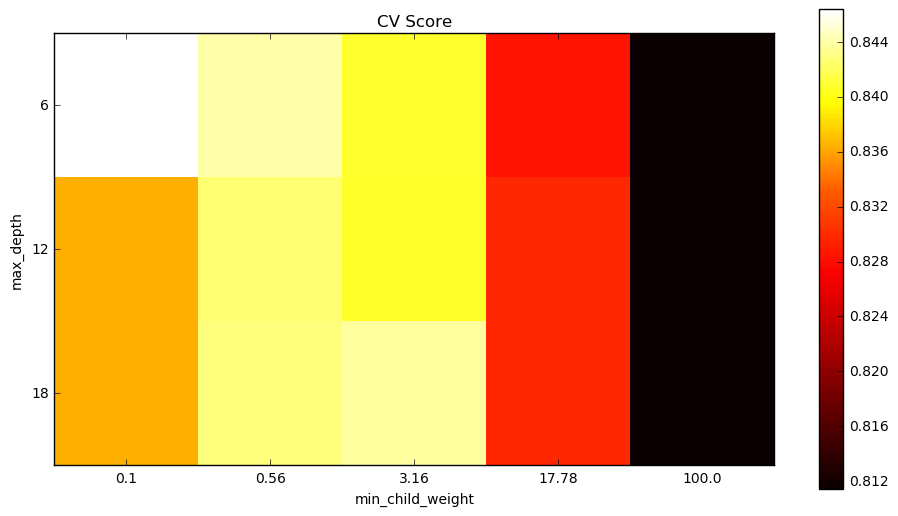

<function __main__.plotgrid>

In [8]:
# get the scores and values for the sliders
scores = np.fabs([x[1] for x in grid.grid_scores_])
vmin = np.min(scores)
vmax = np.max(scores)
mean = np.mean(scores)
step = (vmax-vmin)/100.

widgets.interact(plotgrid, grid=fixed(grid), vmin=FloatSlider(min=vmin, max=vmax, step=step, value=vmin), 
                 vmax=FloatSlider(min=vmin, max=vmax, step=step, value=vmax), 
                 midpoint=FloatSlider(min=vmin, max=vmax, step=step, value=mean))

The sliders allow you to change the color scales so you're not swamped by terrible scores or have trouble discerning nearby CV scores.  Here the grid is very coarse, so don't need to use it.  

Now we tighten the grid a bit:

In [9]:
max_depth = [4,6,8,10]
min_child_weight = np.logspace(np.log10(0.5),np.log10(10), 6)

param_grid = dict(max_depth=max_depth, min_child_weight=min_child_weight)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='average_precision',iid=False, cv=5)
grid.fit(df[features],df['Stable'])

# get the names of the parameters
param_names = param_grid.keys()
param_vals = [[val for val in param_grid[param_name]] for param_name in param_names]
param_val_names = {param_name:["{0}".format(val) for val in param_grid[param_name]] for param_name in param_names}

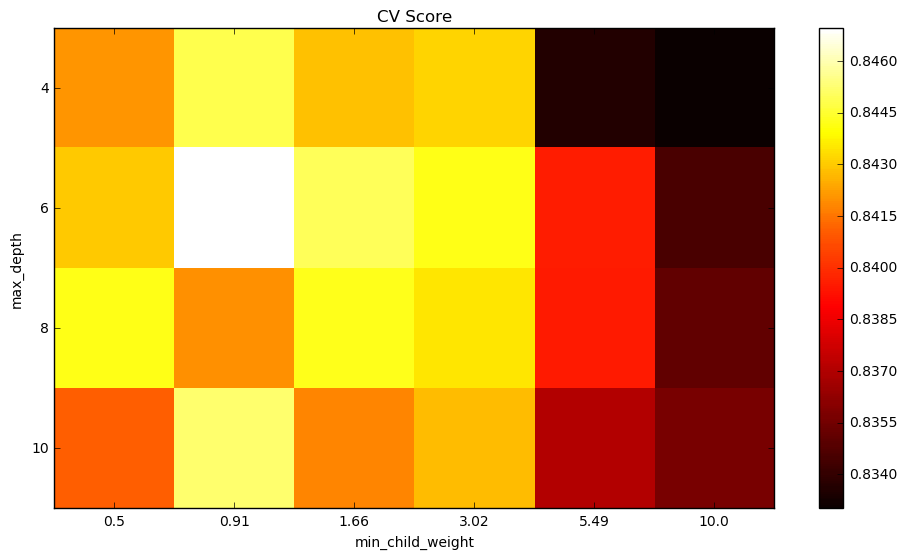

<function __main__.plotgrid>

In [10]:
# get the scores and values for the sliders
scores = np.fabs([x[1] for x in grid.grid_scores_])
vmin = np.min(scores)
vmax = np.max(scores)
mean = np.mean(scores)
step = (vmax-vmin)/100.

widgets.interact(plotgrid, grid=fixed(grid), vmin=FloatSlider(min=vmin, max=vmax, step=step, value=vmin), 
                 vmax=FloatSlider(min=vmin, max=vmax, step=step, value=vmax), 
                 midpoint=FloatSlider(min=vmin, max=vmax, step=step, value=mean))

Here the sliders help a bit more.  Looks like `max_depth = 12`, `min_child_weight`=30 is a region with good scores.  The widgets below allow you to look at 1D cuts through the 2D plot above:

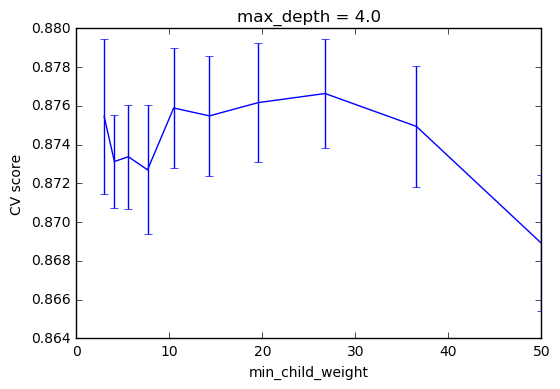

<function __main__.plot1dcut>

In [16]:
fixed_param=param_names[0]
widgets.interact(plot1dcut, grid=fixed(grid), param_names = fixed(param_names), fixed_param_name = fixed(fixed_param), fixed_value_name=SelectionSlider(description=fixed_param, options=param_val_names[fixed_param]))

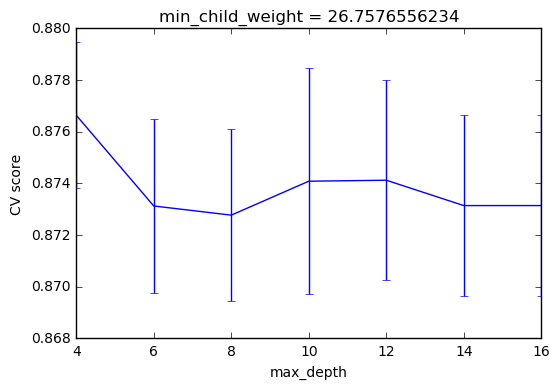

In [17]:
fixed_param=param_names[1]
widgets.interact(plot1dcut, grid=fixed(grid), param_names = fixed(param_names), fixed_param_name = fixed(fixed_param), fixed_value_name=SelectionSlider(description=fixed_param, options=param_val_names[fixed_param]))

Lower values of max_depth and higher values of min_child_weight help avoid overfitting, but if you go too far the model will do badly.  So I think we want to go with more conservative values.  Here it seems like max_depth of 4 does well, which I think suggests we don't have many features that will help the algorithm!  So let's choose:

In [11]:
model.set_params(max_depth=6, min_child_weight=1.)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1.0, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=1)

In [12]:
subsample = np.linspace(0.2,1,5, endpoint=True)
colsample_bytree = np.linspace(0.5,1,5, endpoint=True)

param_grid = dict(subsample=subsample, colsample_bytree=colsample_bytree)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='average_precision',iid=False, cv=5)
grid.fit(df[features],df['Stable'])

# get the names of the parameters
param_names = param_grid.keys()
param_vals = [[val for val in param_grid[param_name]] for param_name in param_names]
param_val_names = {param_name:["{0}".format(val) for val in param_grid[param_name]] for param_name in param_names}

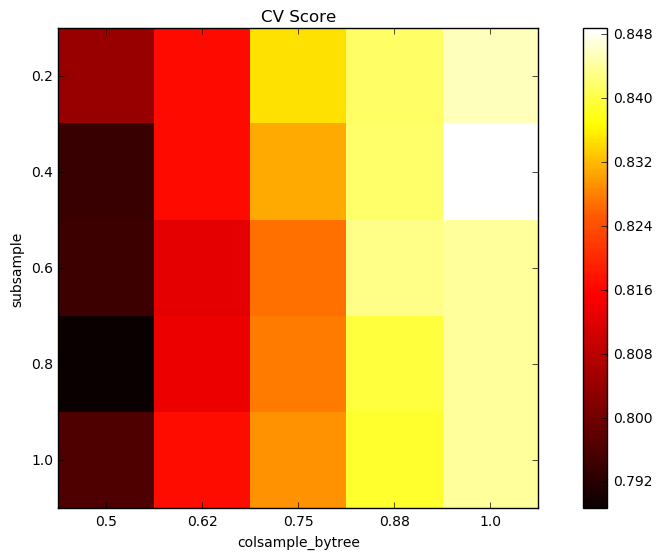

<function __main__.plotgrid>

In [13]:
# get the scores and values for the sliders
scores = np.fabs([x[1] for x in grid.grid_scores_])
vmin = np.min(scores)
vmax = np.max(scores)
mean = np.mean(scores)
step = (vmax-vmin)/100.

widgets.interact(plotgrid, grid=fixed(grid), vmin=FloatSlider(min=vmin, max=vmax, step=step, value=vmin), 
                 vmax=FloatSlider(min=vmin, max=vmax, step=step, value=vmax), 
                 midpoint=FloatSlider(min=vmin, max=vmax, step=step, value=mean))

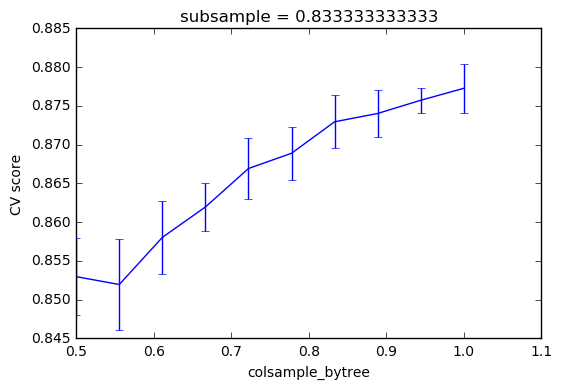

In [24]:
fixed_param=param_names[0]
widgets.interact(plot1dcut, grid=fixed(grid), param_names = fixed(param_names), fixed_param_name = fixed(fixed_param), fixed_value_name=SelectionSlider(description=fixed_param, options=param_val_names[fixed_param]))

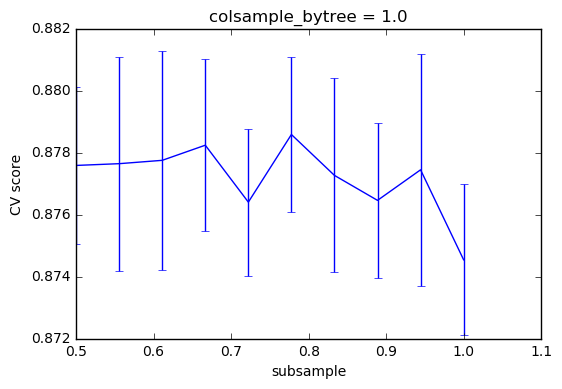

In [25]:
fixed_param=param_names[1]
widgets.interact(plot1dcut, grid=fixed(grid), param_names = fixed(param_names), fixed_param_name = fixed(fixed_param), fixed_value_name=SelectionSlider(description=fixed_param, options=param_val_names[fixed_param]))

We choose the approximate maximum:

In [14]:
model.set_params(subsample=0.4, colsample_bytree=1.)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1.0, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.4)

Now we lower the `learning_rate` (so we have to raise `n_estimators`) to get a slightly better model:

In [15]:
model.set_params(n_estimators=5000)
learning_rate = np.logspace(-3, -0.5, 10)

param_grid = dict(learning_rate=learning_rate)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='average_precision',iid=False, cv=5)
grid.fit(df[features],df['Stable'])

# get the names of the parameters
param_names = param_grid.keys()
param_vals = [[val for val in param_grid[param_name]] for param_name in param_names]
param_val_names = {param_name:["{0}".format(val) for val in param_grid[param_name]] for param_name in param_names}

In [17]:
grid.grid_scores_

[mean: 0.84198, std: 0.01249, params: {'learning_rate': 0.001},
 mean: 0.83888, std: 0.01258, params: {'learning_rate': 0.0018957356524063754},
 mean: 0.83399, std: 0.00992, params: {'learning_rate': 0.0035938136638046258},
 mean: 0.82940, std: 0.00799, params: {'learning_rate': 0.0068129206905796153},
 mean: 0.82413, std: 0.00893, params: {'learning_rate': 0.01291549665014884},
 mean: 0.81964, std: 0.01196, params: {'learning_rate': 0.024484367468222266},
 mean: 0.81613, std: 0.01130, params: {'learning_rate': 0.046415888336127795},
 mean: 0.80991, std: 0.00754, params: {'learning_rate': 0.087992254356910743},
 mean: 0.80346, std: 0.01230, params: {'learning_rate': 0.1668100537200059},
 mean: 0.79209, std: 0.00680, params: {'learning_rate': 0.31622776601683794}]

So this is probably close to our best model:

In [18]:
model.set_params(learning_rate=0.001, n_estimators=10000)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1.0,
       gamma=0, learning_rate=0.001, max_delta_step=0, max_depth=6,
       min_child_weight=1.0, missing=None, n_estimators=10000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.4)


Model Report
Accuracy : 0.8527
AUC Score (Test): 0.841895


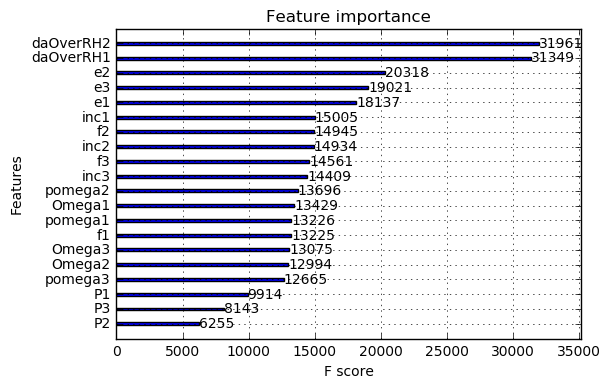

In [19]:
model.fit(df[features], df['Stable'])
        
#Predict training set:
dtrain_predictions = model.predict(df[features])
dtest_predictions = model.predict(dftest[features])
dtrain_predprob = model.predict_proba(df[features])[:,1]
dtest_predprob = model.predict_proba(dftest[features])[:,1]

#Print model report:
print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(dftest['Stable'].values, dtest_predictions)
#print "AUC Score (Train): %f" % metrics.roc_auc_score(df['Stable'], dtrain_predprob)
print "AUC Score (Test): %f" % metrics.average_precision_score(dftest['Stable'], dtest_predprob)

xgb.plot_importance(model)

In [20]:
y_pred=model.predict_proba(dftest[features])

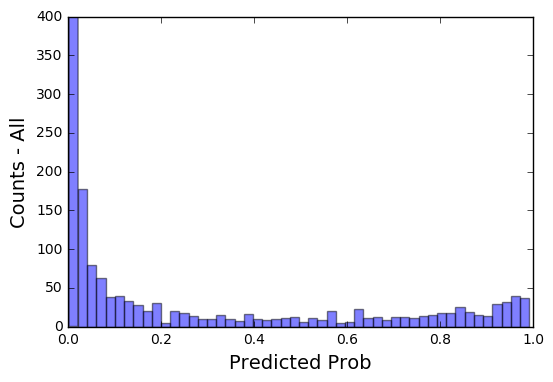

In [21]:
fig, ax= plt.subplots()
ax.hist(y_pred[:,1], bins=50, alpha=0.5)
ax.set_xlabel('Predicted Prob', fontsize=14)
ax.set_ylabel('Counts - All', fontsize=14)
plt.show()

In [51]:
np.savetxt('../data/StableIC.txt', Stable)
np.savetxt('../data/UnstableIC.txt', Unstable)

In [52]:
Stable2 = np.loadtxt('../data/StableIC.txt')
Unstable2 = np.loadtxt('../data/UnstableIC.txt')

(0, 160)

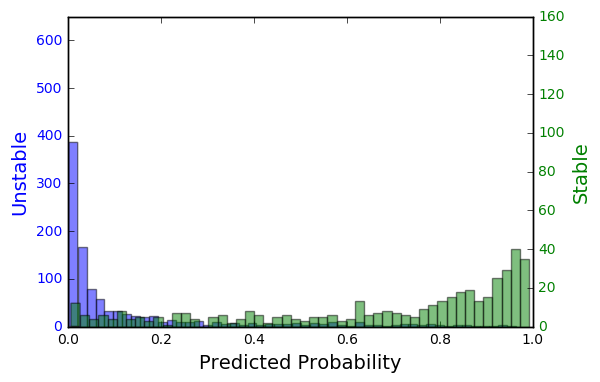

In [53]:
# Histogram:

bins = 50
y_pred=model.predict_proba(dftest[features])
Stable=y_pred[dftest['Stable'].values][:,1]
Unstable=y_pred[~dftest['Stable'].values][:,1]


#df['Predict'].loc[df['Truth']==1]

fig, ax1 = plt.subplots()
ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue')
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green')
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
 
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,650])
ax2.set_ylim([0,160])

In [35]:
dftest.loc[4002]

Stable                          False
Norbits_instability       1.28508e+06
Norbits                         1e+07
Mplanet                       1.5e-05
RH/a                        0.0215443
a1                          0.0582047
P1                          0.0140421
e1                          0.0161573
pomega1                      0.160546
inc1                        0.0131669
Omega1                       -1.59886
f1                           0.400726
x1                          0.0485359
y1                          0.0305194
z1                        0.000627578
vx1                          -13.9303
vy1                           22.4663
vz1                         -0.191652
a2                          0.0679522
P2                          0.0177133
e2                          0.0056809
pomega2                       3.02863
inc2                      0.000755456
Omega2                      -0.032114
f2                           -4.45033
x2                          0.0101094
y2          

In [33]:
ari = dftest[["daOverRH1", "daOverRH2"]]

In [34]:
ari['P2/P1'] = dftest['P2']/dftest['P1']
ari['P3/P2'] = dftest['P3']/dftest['P2']

/mnt/raid-cita/dtamayo/p2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/mnt/raid-cita/dtamayo/p2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [39]:
ari["predprob"] = model.predict_proba(dftest[features])[:,1]
ari.head()

/mnt/raid-cita/dtamayo/p2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,daOverRH1,daOverRH2,P2/P1,P3/P2,predprob
Sim_ID,,,,,
1648,6.879240,7.131643,1.230348,1.239099,0.264850
3471,8.496936,5.371167,1.286789,1.178497,0.012564
3849,6.822671,5.825163,1.228390,1.194028,0.005195
3537,5.092680,6.103170,1.169004,1.203572,0.011169
4214,8.928228,5.186531,1.301979,1.172200,0.076634


In [40]:
ari["predstable"] = ari["predprob"]>0.45
ari["Norbits_instability"] = dftest["Norbits_instability"]

/mnt/raid-cita/dtamayo/p2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/mnt/raid-cita/dtamayo/p2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [42]:
ari["Stable"] = dftest["Stable"]
ari.head()

/mnt/raid-cita/dtamayo/p2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,daOverRH1,daOverRH2,P2/P1,P3/P2,predprob,predstable,Norbits_instability,Stable
Sim_ID,,,,,,,,
1648,6.879240,7.131643,1.230348,1.239099,0.264850,False,1.000000e+07,True
3471,8.496936,5.371167,1.286789,1.178497,0.012564,False,8.233677e+05,False
3849,6.822671,5.825163,1.228390,1.194028,0.005195,False,7.204145e+03,False
3537,5.092680,6.103170,1.169004,1.203572,0.011169,False,5.851915e+03,False
4214,8.928228,5.186531,1.301979,1.172200,0.076634,False,6.435885e+06,False


In [43]:
ari.to_csv("/mnt/raid-cita/dtamayo/Stability/Analysis/ari.csv", encoding='ascii')

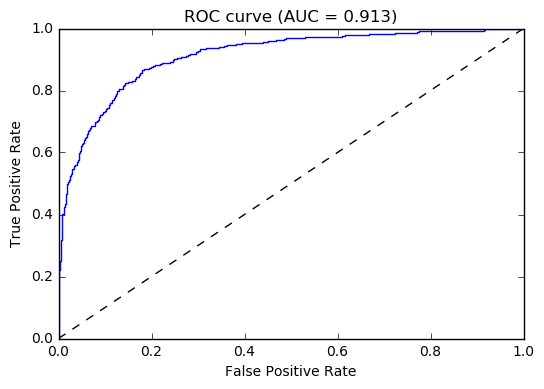

In [35]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(dftest['Stable'], y_pred[:,1])
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(dftest['Stable'], dtest_predprob)))

In [36]:
for i in range(0,len(fpr), 10):
    print("Threshold {0}, FPR = {1}, TPR = {2}".format(thresholds[i], fpr[i], tpr[i]))

Threshold 0.991706132889, FPR = 0.0, TPR = 0.00225225225225
Threshold 0.925097882748, FPR = 0.00473484848485, TPR = 0.25
Threshold 0.851689875126, FPR = 0.0104166666667, TPR = 0.400900900901
Threshold 0.836758673191, FPR = 0.0151515151515, TPR = 0.432432432432
Threshold 0.795364737511, FPR = 0.0208333333333, TPR = 0.5
Threshold 0.771784961224, FPR = 0.0265151515152, TPR = 0.524774774775
Threshold 0.738261282444, FPR = 0.0340909090909, TPR = 0.554054054054
Threshold 0.709416806698, FPR = 0.0426136363636, TPR = 0.574324324324
Threshold 0.665696501732, FPR = 0.0492424242424, TPR = 0.605855855856
Threshold 0.633842229843, FPR = 0.0549242424242, TPR = 0.637387387387
Threshold 0.617649674416, FPR = 0.063446969697, TPR = 0.65990990991
Threshold 0.573699533939, FPR = 0.0691287878788, TPR = 0.68018018018
Threshold 0.557369351387, FPR = 0.0795454545455, TPR = 0.695945945946
Threshold 0.517530679703, FPR = 0.0899621212121, TPR = 0.713963963964
Threshold 0.464368849993, FPR = 0.10321969697, TPR = 

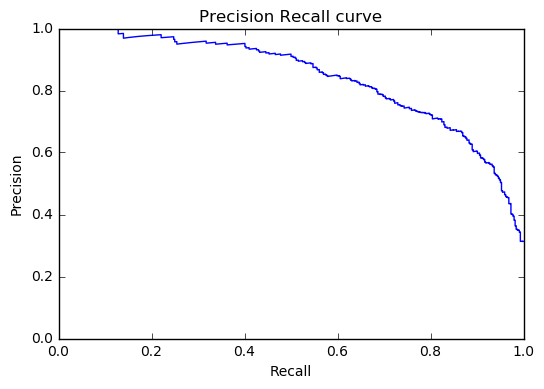

In [57]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(dftest['Stable'], y_pred[:,1])
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall curve')

In [55]:
np.savetxt('../data/thresholdsIC.txt', thresholds)
np.savetxt('../data/recallIC.txt', recall)
np.savetxt('../data/precisionIC.txt', precision)

In [56]:
thresholds2 = np.loadtxt('../data/thresholdsIC.txt')
recall2 = np.loadtxt('../data/recallIC.txt')
precision2 = np.loadtxt('../data/precisionIC.txt')

In [38]:
for i in range(0,len(recall), 40):
    print("Threshold {0}, Precision = {1}, Recall = {2}".format(thresholds[i], precision[i], recall[i]))

Threshold 0.00658300146461, Precision = 0.313338038109, Recall = 1.0
Threshold 0.0079172924161, Precision = 0.320261437908, Recall = 0.993243243243
Threshold 0.00957423634827, Precision = 0.329842931937, Recall = 0.993243243243
Threshold 0.0111380619928, Precision = 0.3400154202, Recall = 0.993243243243
Threshold 0.0130421323702, Precision = 0.349244232299, Recall = 0.988738738739
Threshold 0.014417514205, Precision = 0.359079704191, Recall = 0.984234234234
Threshold 0.0166830364615, Precision = 0.370433305013, Recall = 0.981981981982
Threshold 0.0190163552761, Precision = 0.382585751979, Recall = 0.97972972973
Threshold 0.0219434481114, Precision = 0.395624430264, Recall = 0.977477477477
Threshold 0.0248455870897, Precision = 0.408703878903, Recall = 0.972972972973
Threshold 0.0282755363733, Precision = 0.424778761062, Recall = 0.972972972973
Threshold 0.0340619422495, Precision = 0.440122824974, Recall = 0.968468468468
Threshold 0.0395329110324, Precision = 0.456776947705, Recall = 0

In [34]:
quant = np.arange(0.01, 1.0, 0.01)*100
prob_Stable = np.percentile(Stable,quant)

quant_f = interp1d(prob_Stable, quant)
prob_f=interp1d(quant, prob_Stable)

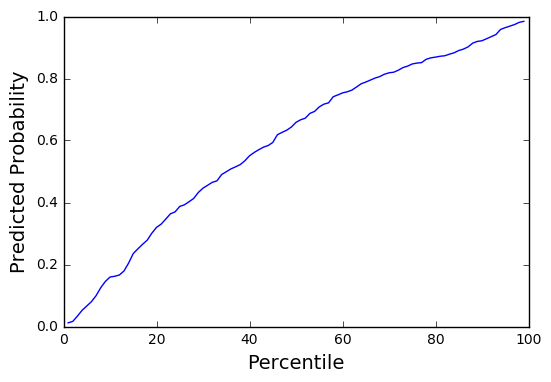

In [35]:
fig, ax = plt.subplots()
plt.plot(quant, prob_Stable)
ax.set_xlabel('Percentile', fontsize=14)
ax.set_ylabel('Predicted Probability', fontsize=14)
plt.show()

In [37]:
_tv = []
_accv = []
_accnormv = []
for i, thresh in enumerate(prob_Stable):
    _loc_yes = Stable >= thresh
    _loc_no = Unstable >= thresh
    _yes = Stable[_loc_yes].shape[0]
    _no = Unstable[_loc_no].shape[0]
    _total = _yes + _no
    if i % 5 == 0:
        print(thresh, _yes*100 / _total)
    _tv.append(thresh)
    _accv.append(_yes*100/_total)
#    _accnormv.append(_yes / Stable.shape[0] / (_yes / Stable.shape[0] + _no / Unstable.shape[0]))
_tv = np.asarray(_tv)
_accv = np.asarray(_accv)
#_accnormv = np.asarray(_accnormv)

(0.011747720669955015, 33)
(0.079912357330322287, 46)
(0.16199764385819435, 52)
(0.25064994275569918, 59)
(0.33018910586833961, 64)
(0.39256731867790223, 66)
(0.45565427839756023, 71)
(0.50832029581069949, 73)
(0.56136916100978851, 75)
(0.61862298250198366, 78)
(0.6668562018871308, 81)
(0.71722491025924684, 84)
(0.75701809287071242, 85)
(0.79495857596397401, 85)
(0.82019906878471383, 86)
(0.84968152999877922, 90)
(0.87178910374641416, 92)
(0.89482335448265082, 95)
(0.92838658750057212, 100)
(0.96896204948425302, 100)


Pred prob for 90 percent accuracy: 0.839913
Pred prob for 80 percent accuracy: 0.643418


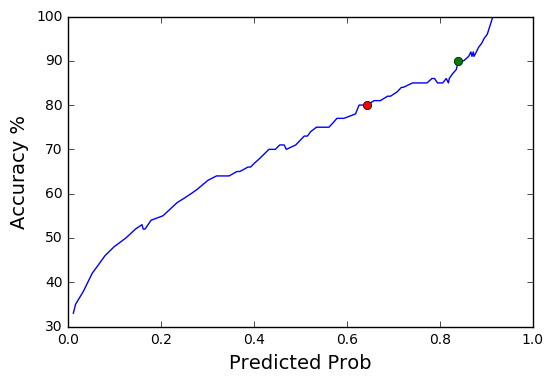

To obtain 90 percent accuracy need to go to 74 quantile
To obtain 80 percent accuracy need to go to 49 quantile


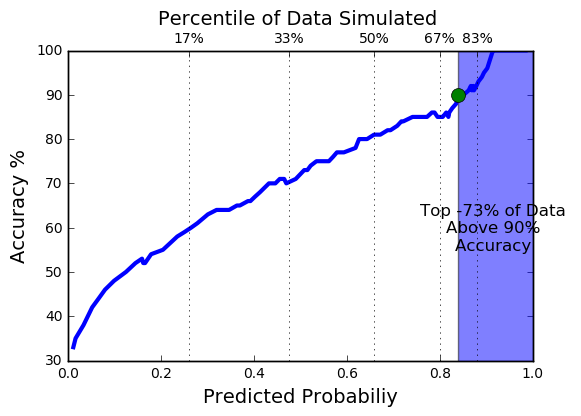

In [38]:
# Find 90% accuracy:
# calculate fit
thr_f = interp1d(_accv, _tv)

# calculate new x's and y's
thresh_fit = thr_f(_accv)
thresh_90=thr_f(90)
thresh_80=thr_f(80)

print('Pred prob for 90 percent accuracy: %f' % thresh_90)
print('Pred prob for 80 percent accuracy: %f' % thresh_80)

fig, ax1 = plt.subplots()
plt.plot(_tv, _accv , thresh_90, 90, 'o', thresh_80, 80, 'o')

ax1.set_xlabel('Predicted Prob', fontsize=14)
ax1.set_ylabel('Accuracy %', fontsize=14)
plt.show()

# calculate new x's and y's
quant_fit = quant_f(prob_Stable)
quant_acc90=quant_f(thresh_90)
quant_acc80=quant_f(thresh_80)
print('To obtain 90 percent accuracy need to go to %1.f quantile' % quant_acc90)
print('To obtain 80 percent accuracy need to go to %1.f quantile' % quant_acc80)


fig, ax1 = plt.subplots()
#plt.plot(f(_tv),_accv *100., f(thresh_90),0.9*100., 'o', markersize=10, color=orangeWCN, LineWidth=3)
ax1.plot(_tv,_accv, thresh_90, 90, 'o', markersize=10,  lw=3, zorder=60)
ax1.set_xlabel('Predicted Probabiliy', fontsize=14)

ax1.set_ylabel('Accuracy %', fontsize=14)
ay2 = ax1.twiny()

# setting grid:
#plt.grid()
xticks=prob_f(np.array([0.167, 0.333, 0.5, 0.667, 0.833])*100)
xlabels=['17%', '33%', '50%', '67%','83%']


ay2.xaxis.grid(True, which='major', zorder=50)

ay2.set_xlabel('Percentile of Data Simulated ' , fontsize=14)
ay2.set_xlim(ax1.get_xlim())
ay2.set_xticks(xticks, minor=False)
ay2.set_xticklabels(xlabels)



ax1.axvspan(thresh_90, 1, alpha=0.5, zorder=20)
legend = ax1.text((1-thresh_90)/2+thresh_90, 55, 'Top %.0f%% of Data \nAbove 90%% \nAccuracy ' %((1-quant_f(thresh_90))),
                  fontsize=12, ha='center', zorder=40)

